<a href="https://colab.research.google.com/github/PedroTrama/TCC-Recommendation-Systems/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MovieLens Recommendation System
Developed as my final thesis for UNICAMP's Faculdade de Tecnologia course in Information Systems.<br><br>
The system uses matrix factorization, mean squared error, k-means clustering and other algorithms to pre-process data, train, test and create recommendations.<br><br>
Database: https://grouplens.org/datasets/movielens/<br>
movies_df: https://drive.google.com/file/d/1PwM8vMxjyx6abQ6G9mobb509fhKaYVC3/view?usp=sharing<br>
ratings_df: https://drive.google.com/file/d/1TmLZJh3w398GH-8nrg84FjiVvXyrD4D5/view?usp=sharing

In [3]:
 # Mounting drive for connection

from google.colab import drive
drive.mount('/content/drive')

# Libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from torch.utils.data.dataset import Dataset
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, random_split

# Accessing dataset
movies_df = pd.read_csv('/content/drive/MyDrive/movielens/movie.csv') # movies metadata
ratings_df = pd.read_csv('/content/drive/MyDrive/movielens/rating.csv') # users' reviews

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Pre-processing

In [5]:
# Tresholds
user_rating_threshold = 500
movie_rating_threshold = 500
top_n_users = 1000

# Reducing Data
user_counts = ratings_df.groupby('userId').size()
movie_counts = ratings_df.groupby('movieId').size()

active_users = user_counts[user_counts >= user_rating_threshold].index
popular_movies = movie_counts[movie_counts >= movie_rating_threshold].index

ratings_df = ratings_df[(ratings_df['userId'].isin(active_users)) & (ratings_df['movieId'].isin(popular_movies))]

user_counts = ratings_df.groupby('userId').size()
top_users = user_counts.nlargest(top_n_users).index

ratings_df = ratings_df[ratings_df['userId'].isin(top_users)]

popular_movies = ratings_df['movieId'].unique()
movies_df = movies_df[movies_df['movieId'].isin(popular_movies)]

In [10]:
# Data review
movie_names = movies_df.set_index('movieId')['title'].to_dict()
unique_movies = len(ratings_df.movieId.unique())
unique_users = len(ratings_df.userId.unique())

print(f'movies_df size: {movies_df.shape}')
print(f'ratings_df size: {ratings_df.shape}')
print(f'---------------------------')
print(f'Number of movies: {unique_movies}')
print(f'Number of users: {unique_users}')
print(f'Number of ratings: {len(ratings_df)}')
print(f'--------------------------')
print(f'Rating matrix size: {unique_users * unique_movies} items')
print(f'Sparsity: {len(ratings_df) / (unique_users * unique_movies) * 100:.2f}%')

movies_df size: (897, 3)
ratings_df size: (613900, 4)
---------------------------
Number of movies: 897
Number of users: 1000
Number of ratings: 613900
--------------------------
Rating matrix size: 897000 items
Sparsity: 68.44%


# 2. Learning



In [12]:
# Matrix factorization
class MatrixFactorization(torch.nn.Module):
    def __init__(self, unique_users, unique_movies, factors=20):
        super().__init__()

        self.user_factors = torch.nn.Embedding(unique_users, factors)
        self.movie_factors = torch.nn.Embedding(unique_movies, factors)

        torch.nn.init.xavier_uniform_(self.user_factors.weight)
        torch.nn.init.xavier_uniform_(self.movie_factors.weight)

    def forward(self, data):
        users, movies = data[:,0], data[:,1]
        return (self.user_factors(users)*self.movie_factors(movies)).sum(1)

    def predict(self, user, movie):
        data = torch.tensor([[user, movie]])
        return self.forward(data)

# Adapting to PyTorch
class Loader(Dataset):
    def __init__(self):
        self.ratings = ratings_df.copy()

        users = ratings_df.userId.unique()
        movies = ratings_df.movieId.unique()

        self.userid2idx = {o:i for i,o in enumerate(users)}
        self.movieid2idx = {o:i for i,o in enumerate(movies)}

        self.idx2userid = {i:o for o,i in self.userid2idx.items()}
        self.idx2movieid = {i:o for o,i in self.movieid2idx.items()}

        self.ratings.movieId = ratings_df.movieId.apply(lambda x: self.movieid2idx[x])
        self.ratings.userId = ratings_df.userId.apply(lambda x: self.userid2idx[x])

        self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
        self.y = self.ratings['rating'].values

        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

In [18]:
#Training Setup
epochs = 3 #256
batch_size = 128
cuda = torch.cuda.is_available()
model = MatrixFactorization(unique_users, unique_movies, factors=8)
print("Running with GPU acceleration:", cuda)
print("-------------------------------------")
print(model)
print("-------------------------------------")

if cuda:
    model = model.cuda()

#MSE
loss_fn = torch.nn.MSELoss()

#Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dataset = Loader()
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
print(f"Training size: {train_size}, Test size: {test_size}")

train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Running with GPU acceleration: True
-------------------------------------
MatrixFactorization(
  (user_factors): Embedding(1000, 8)
  (movie_factors): Embedding(897, 8)
)
-------------------------------------
Training size: 491120, Test size: 122780


In [19]:
#Training
for epoch in tqdm(range(epochs)):
    model.train()
    train_losses = []

    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs.squeeze().float(), y.float())
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses):.4f}")

# Testing
model.eval()
test_preds, test_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()

        outputs = model(x)
        test_preds.extend(outputs.squeeze().cpu().numpy())
        test_labels.extend(y.cpu().numpy())

mse = mean_squared_error(test_labels, test_preds)
print(f"\nTest MSE: {mse:.4f}")

 33%|███▎      | 1/3 [00:09<00:18,  9.45s/it]

Epoch 1/3, Train Loss: 4.4583


 67%|██████▋   | 2/3 [00:17<00:08,  8.49s/it]

Epoch 2/3, Train Loss: 0.6680


100%|██████████| 3/3 [00:25<00:00,  8.60s/it]

Epoch 3/3, Train Loss: 0.6679



Test MSE: 0.6688


#3. Recommending

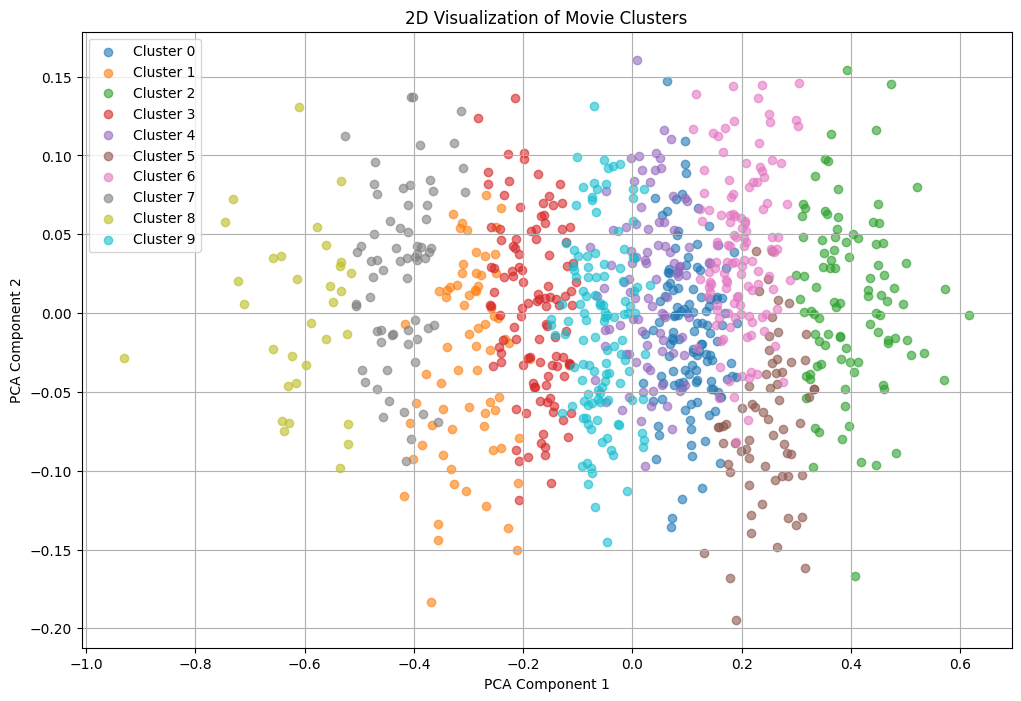

In [22]:
# K-means clustering
trained_movie_embeddings = model.movie_factors.weight.data.cpu().numpy()
kmeans = KMeans(n_clusters=10, random_state=0).fit(trained_movie_embeddings)

# Reducing dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(trained_movie_embeddings)
plt.figure(figsize=(12, 8))
for cluster in range(10):
    cluster_points = reduced_embeddings[kmeans.labels_ == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.6)

plt.title("2D Visualization of Movie Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Display top 10 movies in each cluster
for cluster in range(10):
    print(f"\nCluster #{cluster}")
    movs = []

    for movidx in np.where(kmeans.labels_ == cluster)[0]:
        movid = dataset.idx2movieid[movidx]
        rat_count = len(ratings_df[ratings_df['movieId'] == movid])
        movs.append((movie_names[movid], rat_count))

    for mov in sorted(movs, key=lambda x: x[1], reverse=True)[:10]:
        print("\t", mov[0])


Cluster #0
	 Jurassic Park (1993)
	 Men in Black (a.k.a. MIB) (1997)
	 Batman (1989)
	 Gladiator (2000)
	 Indiana Jones and the Temple of Doom (1984)
	 There's Something About Mary (1998)
	 Who Framed Roger Rabbit? (1988)
	 Austin Powers: International Man of Mystery (1997)
	 Total Recall (1990)
	 Fifth Element, The (1997)

Cluster #1
	 Star Wars: Episode I - The Phantom Menace (1999)
	 Austin Powers: The Spy Who Shagged Me (1999)
	 Pretty Woman (1990)
	 Armageddon (1998)
	 Twister (1996)
	 Ace Ventura: Pet Detective (1994)
	 Mars Attacks! (1996)
	 Lost World: Jurassic Park, The (1997)
	 Starship Troopers (1997)
	 Dumb & Dumber (Dumb and Dumber) (1994)

Cluster #2
	 Matrix, The (1999)
	 Back to the Future (1985)
	 Sixth Sense, The (1999)
	 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
	 Silence of the Lambs, The (1991)
	 Star Wars: Episode IV - A New Hope (1977)
	 Pulp Fiction (1994)
	 Star Wars: Episode V - The Empire Strikes Back (1980)
	 Groundhog D